In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 



In [2]:
df = pd.read_csv(r"C:\Users\DELL\Documents\GitHub\ForEx\USDINR\USDINR.csv")
df.head()

,Unnamed: 0,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0,2014-11-07,61.390,61.620,61.340,61.400,USD/INR,61.609403,61.339012,61.390960,61.400000,61.400000,61.400000,0.0,0.000000,0.000000,0.000000,61.7496,62.164424,61.334776
1,1,2014-11-10,61.500,61.635,61.340,61.495,USD/INR,61.625872,61.330301,61.492726,61.403725,61.401881,61.400945,0.0,0.007578,0.001516,0.006063,61.7496,62.164424,61.334776
2,2,2014-11-11,61.530,61.555,61.505,61.508,USD/INR,61.546894,61.500125,61.514536,61.407815,61.403983,61.402010,0.0,0.014466,0.004106,0.010361,61.7496,62.164424,61.334776
3,3,2014-11-12,61.508,61.560,61.350,61.391,USD/INR,61.568238,61.358593,61.504599,61.407155,61.403725,61.401901,0.0,0.010365,0.005358,0.005007,61.7496,62.164424,61.334776
4,4,2014-11-13,61.368,61.623,61.350,61.565,USD/INR,61.636544,61.351053,61.386236,61.413345,61.406919,61.403524,0.0,0.020914,0.008469,0.012445,61.7496,62.164424,61.334776


In [3]:
df.columns

Index(['Unnamed: 0', 'Date', 'Open_price', 'Day_high', 'Day_low',
       'Closing_price', 'Currency Pair', 'Deseasonalized_Day_high',
       'Deseasonalized_Day_low', 'Deseasonalized_Open_price', 'EMA_50',
       'EMA_100', 'EMA_200', 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
       'SMA', 'Upper Band', 'Lower Band'],
      dtype='object')

## Linear regression

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# === Load and prepare ===
# Assume df is already a pandas DataFrame with the columns you mentioned
df = df.copy()
df = df.dropna().reset_index(drop=True)

# --- Features and Target ---
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'   # or 'Deseasonalized_Day_high' etc.

X = df[features]
y = df[target]

# === Walk-forward validation ===
tscv = TimeSeriesSplit(n_splits=5)
lr = LinearRegression()

all_metrics = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    # --- Regression metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # --- Trading metrics ---
    pred_returns = pd.Series(y_pred, index=y_test.index).pct_change().fillna(0)
    actual_returns = df.loc[y_test.index, 'Closing_price'].pct_change().fillna(0)

    # Simple strategy: go long if predicted return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=y_test.index)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    # Directional Accuracy
    def directional_accuracy(actual, predicted):
        actual_diff = np.diff(actual)
        pred_diff = np.diff(predicted)
        return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    da = directional_accuracy(y_test.values, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect Results ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)

y_pred_lr = y_pred
# === Average performance ===
print("\nAverage performance across folds:")
print(metrics_df.mean())


   Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0     1  0.167428  0.196271  0.980625  34.815039  0.443375    -0.004794   
1     2  0.127027  0.169544  0.988326  57.340241  0.455690    -0.005130   
2     3  0.116231  0.158664  0.982549  46.712545  0.411236    -0.007062   
3     4  0.115038  0.150325  0.997599  43.530373  0.454351    -0.005011   
4     5  0.062007  0.083199  0.995562  20.462938  0.470353    -0.001788   

   DirAcc(%)  
0  76.444444  
1  79.111111  
2  76.222222  
3  78.222222  
4  75.777778  

Average performance across folds:
Fold            3.000000
MAE             0.117546
RMSE            0.151601
R2              0.988932
ROI(%)         40.572227
Sharpe          0.447001
MaxDrawdown    -0.004757
DirAcc(%)      77.155556
dtype: float64


Rolling Walk-Forward MAE: 0.1033, RMSE: 0.1400, R2: 0.9996
Directional Accuracy: 77.80%


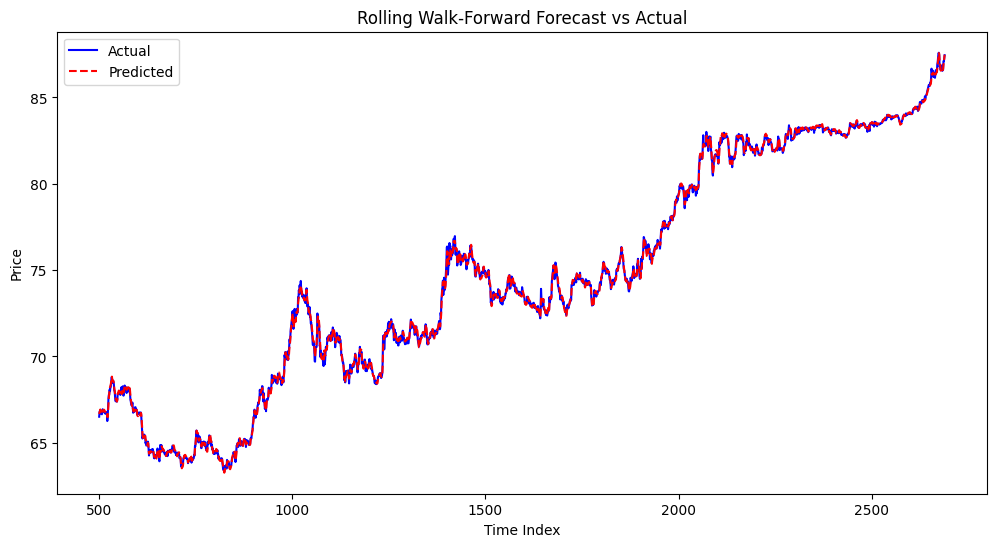

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'  # or try 'Deseasonalized_Day_high', etc.

X = df[features].values
y = df[target].values

# === Walk-forward params ===
train_window = 500   # how many samples in each rolling train set
test_window = 30     # how many samples to predict forward each step

lr = LinearRegression()

# Store results
all_preds, all_actuals, all_idx = [], [], []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

# Convert to Series
y_actual_series = pd.Series(all_actuals, index=all_idx)
y_pred_series = pd.Series(all_preds, index=all_idx)

# === Metrics ===
mae = mean_absolute_error(y_actual_series, y_pred_series)
rmse = np.sqrt(mean_squared_error(y_actual_series, y_pred_series))
r2 = r2_score(y_actual_series, y_pred_series)

print(f"Rolling Walk-Forward MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Directional Accuracy
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

da = directional_accuracy(y_actual_series.values, y_pred_series.values)
print(f"Directional Accuracy: {da:.2f}%")



# Do same for each trained model

# === Plot results ===
plt.figure(figsize=(12,6))
plt.plot(y_actual_series.index, y_actual_series, label="Actual", color="blue")
plt.plot(y_pred_series.index, y_pred_series, label="Predicted", color="red", linestyle="dashed")
plt.title("Rolling Walk-Forward Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()


In [6]:
import pickle

# Example for MLP
with open("lr_model.pkl", "wb") as f:
    pickle.dump(lr, f)

In [9]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 4.5 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------ --------------------- 1.3/2.8 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 6.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.8/30.3 MB 8.4 MB/s eta 0:00:04
   ---- ----------------------------------- 3.7/30.3 MB 8.7 MB/s eta 0:00:04
   ------- -------------------------------- 5.5/30.3 MB 8.6 MB/s eta 0:00:03
   --------- ------------------------------ 7.1/30.3 MB 8.6 MB/s eta 0:00:03
   ------------ --------------------------- 9.2/30.3 MB 8.


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


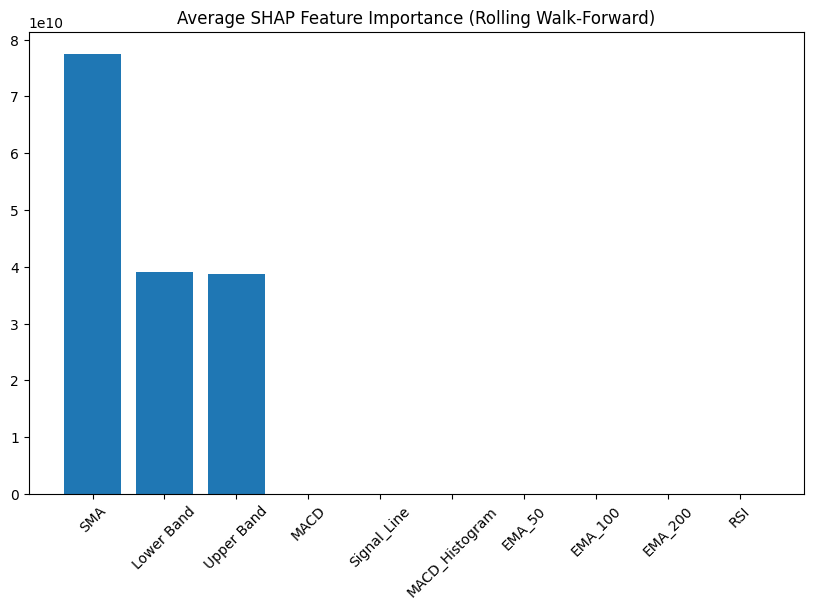

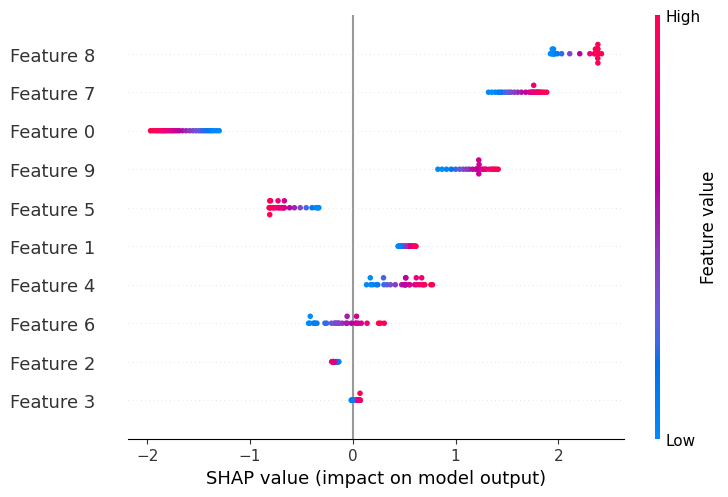

In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === SHAP on Rolling Walk-Forward ===
train_window = 500
test_window = 30
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]

X = df[features].values
y = df['Closing_price'].values

lr = LinearRegression()

all_shap_values = []
all_feature_importance = []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test = X[end:end+test_window]
    
    # Fit
    lr.fit(X_train, y_train)
    
    # SHAP Explainer
    explainer = shap.Explainer(lr, X_train)
    shap_values = explainer(X_test)
    
    # Aggregate mean absolute shap values (feature importance for this window)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

# Convert to array
all_feature_importance = np.array(all_feature_importance)

# === Plot Average Feature Importance Across Walk-Forward ===
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === Optional: Waterfall/Beeswarm for last window ===
shap.plots.beeswarm(shap_values, show=True)


## KNN

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:03<00:00,  8.56it/s]


    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.176800  0.219251   0.798332  2.283216  0.325007    -0.003737   
1      2  0.716960  0.788908  -2.609756 -1.020546 -0.238383    -0.014157   
2      3  0.388520  0.457708  -0.007445  0.188281  0.030040    -0.010282   
3      4  0.498853  0.742175  -0.386556 -1.220093 -0.245726    -0.015262   
4      5  0.659887  0.739453  -5.498083 -0.094683 -0.021929    -0.008226   
..   ...       ...       ...        ...       ...       ...          ...   
68    69  0.394440  0.410892 -52.988011  0.002637  0.002584    -0.002083   
69    70  0.433380  0.517458  -6.038741  0.670100  0.368417    -0.000929   
70    71  0.459280  0.511236  -5.334021  0.540368  0.236505    -0.002192   
71    72  1.216480  1.380271  -4.235668  0.894733  0.337350    -0.001622   
72    73  2.248007  2.312068 -32.764560  2.075914  0.395537    -0.002940   

    DirAcc(%)  
0   48.275862  
1   31.034483  
2   55.172414  
3   24.137931  
4   41.

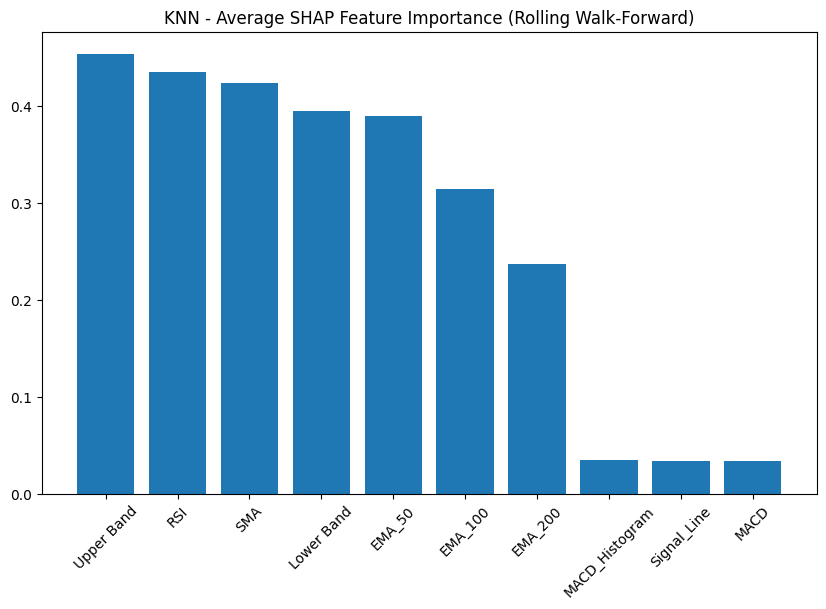

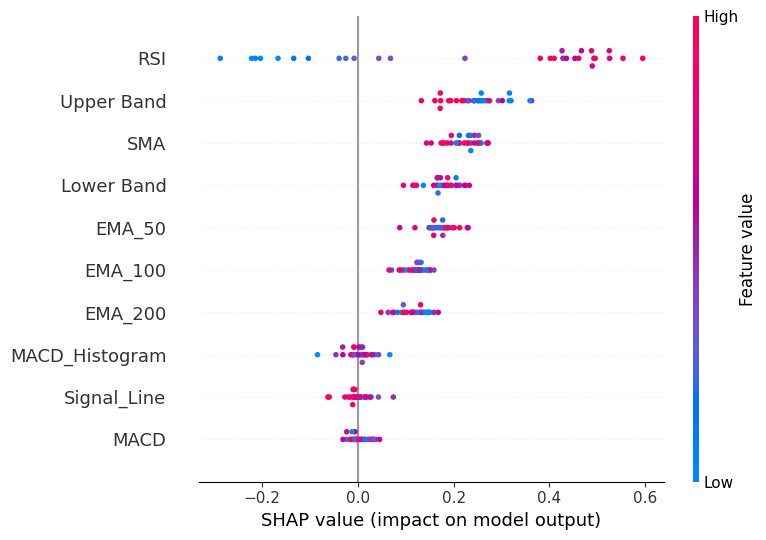

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

knn = KNeighborsRegressor(n_neighbors=5)

all_preds, all_actuals, all_idx = [], [], []
all_feature_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP (KernelExplainer) ---
    background = shap.sample(X_train, 100)  # subset for speed
    explainer = shap.KernelExplainer(knn.predict, background)
    shap_values = explainer.shap_values(X_test, nsamples=100)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predicted vs actual returns
    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    # Strategy: long if pred_return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics into DataFrame ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === Average SHAP importance ===
all_feature_importance = np.array(all_feature_importance)
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("KNN - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === SHAP Beeswarm for last window ===
shap.summary_plot(shap_values, X_test, feature_names=features)


## Catboost

    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.141361  0.194176   0.841822  3.305315  0.475412    -0.002229   
1      2  0.394651  0.446002  -0.153712  1.347111  0.315438    -0.002915   
2      3  0.130381  0.153160   0.887193  2.182728  0.488328     0.000000   
3      4  0.251267  0.351780   0.688494  0.487326  0.181276    -0.002460   
4      5  0.948589  0.985369 -10.538833  0.796090  0.206252    -0.002768   
..   ...       ...       ...        ...       ...       ...          ...   
68    69  0.295770  0.304910 -28.729399  0.423783  0.305686    -0.001333   
69    70  0.201695  0.224774  -0.328122  0.780820  0.448240    -0.001142   
70    71  0.340256  0.397155  -2.822575  1.022277  0.473419    -0.000605   
71    72  0.895172  1.094576  -2.292574  0.898865  0.343078    -0.002128   
72    73  1.464098  1.573801 -14.644416  2.577835  0.567176     0.000000   

    DirAcc(%)  
0   68.965517  
1   62.068966  
2   82.758621  
3   65.517241  
4   65.

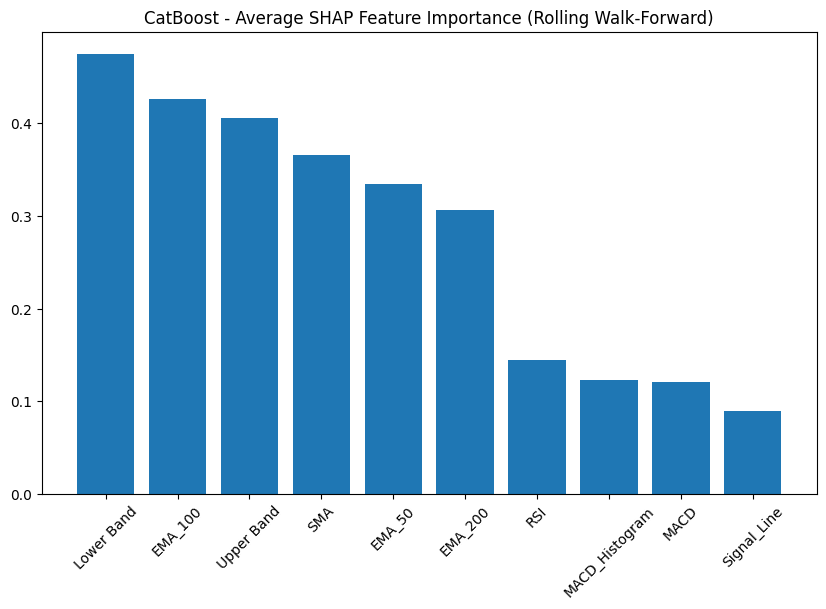

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

cat = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Wrap into CatBoost Pool
    train_pool = Pool(X_train, y_train, feature_names=features)
    test_pool = Pool(X_test, y_test, feature_names=features)

    # Fit model
    cat.fit(train_pool)
    y_pred = cat.predict(test_pool)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values from CatBoost ---
    shap_values = cat.get_feature_importance(type="ShapValues", data=test_pool)
    # Last column of shap_values is expected_value, drop it
    shap_contribs = shap_values[:, :-1]
    mean_abs_shap = np.abs(shap_contribs).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_cat = y_pred

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("CatBoost - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


In [13]:
import pickle

# Example for MLP
with open("cat_model.pkl", "wb") as f:
    pickle.dump(cat, f)

## Gradient Boosting

    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.143471  0.191589   0.846009  3.462441  0.494886    -0.001307   
1      2  0.452676  0.508391  -0.499063  1.518981  0.350651    -0.002290   
2      3  0.270860  0.393886   0.253922  0.723080  0.131084    -0.006176   
3      4  0.337852  0.477533   0.425975  0.564202  0.207716    -0.001986   
4      5  0.711891  0.761623  -5.893567  1.031469  0.274196    -0.002184   
..   ...       ...       ...        ...       ...       ...          ...   
68    69  0.192237  0.201605 -11.997012  0.507124  0.382655    -0.000667   
69    70  0.083273  0.103370   0.719113  0.800718  0.479621    -0.000357   
70    71  0.304059  0.361866  -2.173445  0.859869  0.414113    -0.000438   
71    72  0.819015  1.013274  -1.821613  1.521254  0.589917     0.000000   
72    73  0.727982  0.877430  -3.862786  2.229578  0.566608    -0.000127   

    DirAcc(%)  
0   65.517241  
1   65.517241  
2   58.620690  
3   65.517241  
4   58.

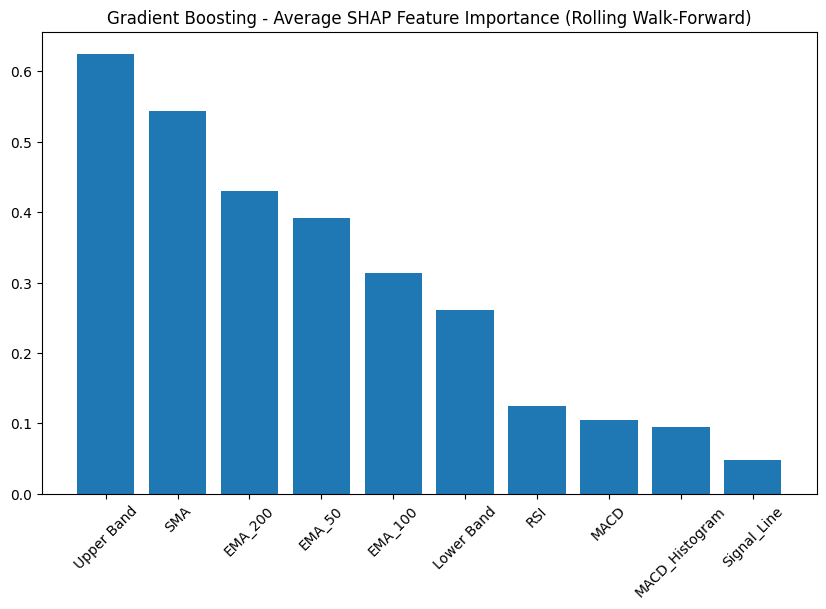

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# === Prepare Data ===
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values ---
    explainer = shap.TreeExplainer(gbr)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("Gradient Boosting - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


## Light GBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1662
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 10
[LightGBM] [Info] Start training from score 65.176988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

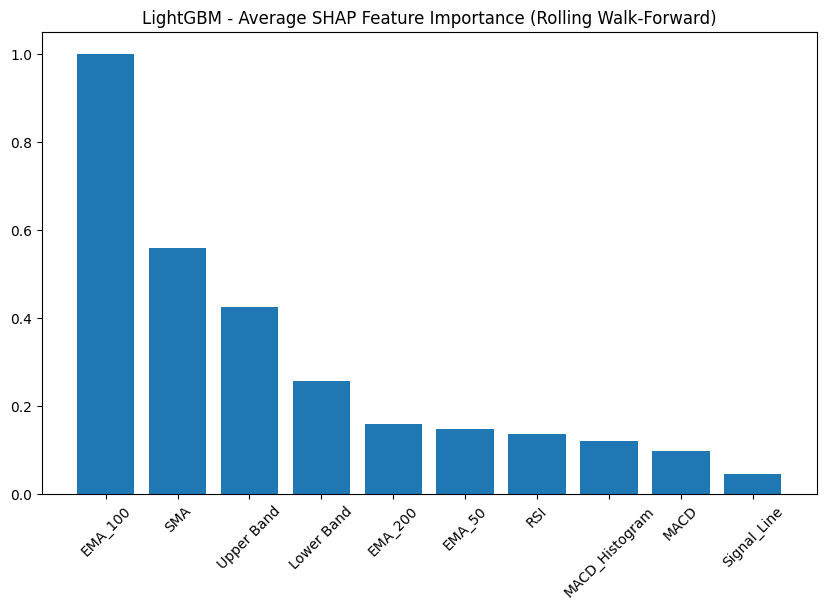

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Rolling walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values ---
    explainer = shap.TreeExplainer(lgbm)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    # Simple trading strategy: long if predicted return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

y_pred_lgb = y_pred

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("LightGBM - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


In [16]:
import pickle

# Example for MLP
with open("lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm, f)

# MLP 


==== MLPRegressor ====
    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.207604  0.259405  0.717700  3.069777  0.430860    -0.002229   
1      2  0.436486  0.531909 -0.640964  1.800280  0.334386    -0.004980   
2      3  0.151784  0.193643  0.819679  1.399241  0.277843    -0.004008   
3      4  0.518388  0.758339 -0.447610  0.278062  0.106226    -0.003609   
4      5  0.516482  0.570851 -2.872669  1.071196  0.260388    -0.003040   
..   ...       ...       ...       ...       ...       ...          ...   
68    69  0.092915  0.111551 -2.979119  0.678744  0.547221    -0.000191   
69    70  0.211092  0.337511 -1.994468  0.648190  0.341370    -0.001278   
70    71  0.333271  0.360172 -2.143816  1.274954  0.590237    -0.000403   
71    72  0.442952  0.510627  0.283443  2.702394  0.673784    -0.000424   
72    73  0.720248  0.774868 -2.792412  3.229728  0.652064    -0.002349   

    DirAcc(%)  
0   62.068966  
1   75.862069  
2   65.517241  
3   65.5172

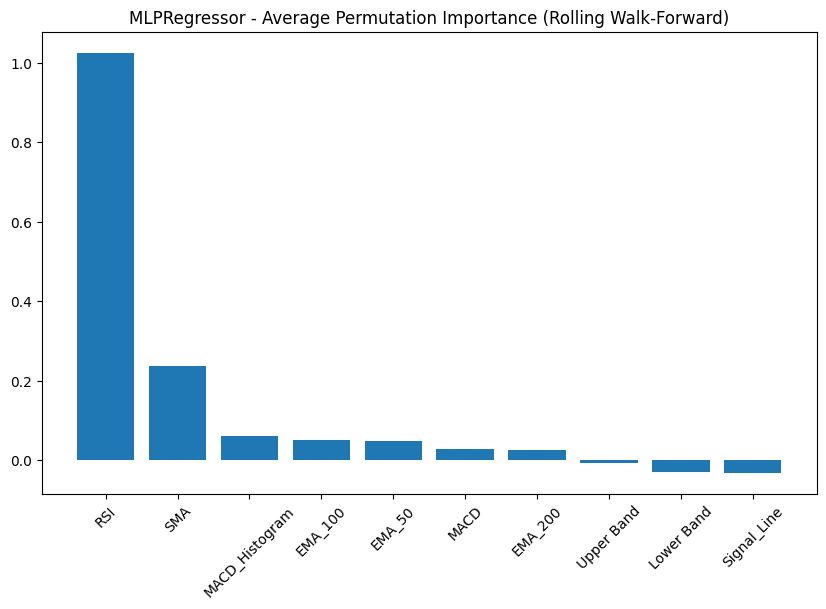


==== SVR ====
    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.277518  0.350143   0.485666  2.585654  0.385950    -0.002573   
1      2  0.643461  0.747410  -2.239983  0.602618  0.092865    -0.009960   
2      3  0.875159  0.996310  -3.773458 -0.735972 -0.141636    -0.012339   
3      4  0.371582  0.414820   0.566844  0.619382  0.352162    -0.000443   
4      5  0.703174  0.817521  -6.942590 -0.662512 -0.137335    -0.011109   
..   ...       ...       ...        ...       ...       ...          ...   
68    69  0.187266  0.208036 -12.839443  0.227238  0.132139    -0.001333   
69    70  0.409680  0.633016  -9.533527  0.084184  0.044349    -0.004092   
70    71  0.277687  0.396065  -2.801634  0.796948  0.365827    -0.001528   
71    72  0.650886  1.107892  -2.373172  0.157617  0.065068    -0.003704   
72    73  2.326263  2.519325 -39.089263  1.700517  0.412620    -0.000912   

    DirAcc(%)  
0   62.068966  
1   65.517241  
2   62.068966  
3   75.8

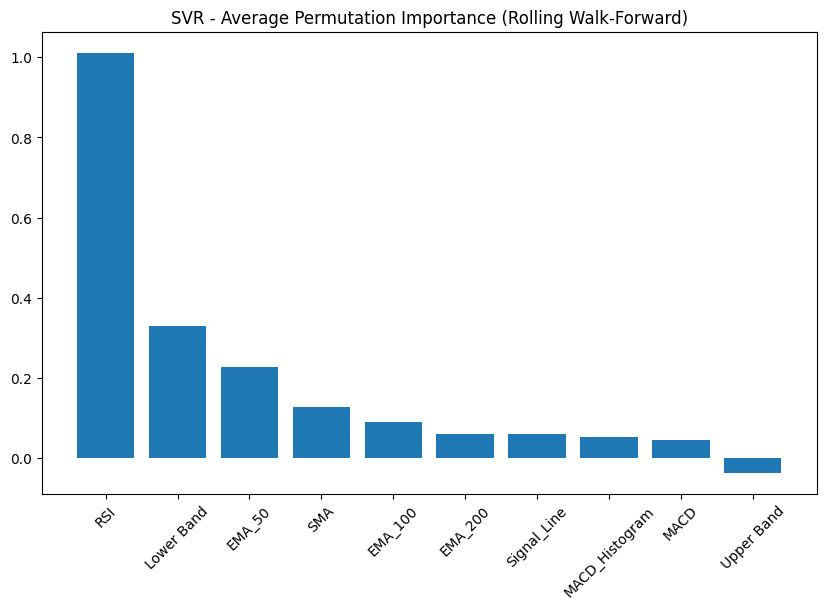

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

# Models
mlp = MLPRegressor(hidden_layer_sizes=(64,32),
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=42)

svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

models = {
    "MLPRegressor": mlp,
    "SVR": svm
}

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

results = {}
all_model_preds = {}  # store final predictions for each model

# === Loop for each model ===
for model_name, model in models.items():
    all_preds, all_actuals, all_idx = [], [], []
    all_importance, all_metrics = [], []

    for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
        end = start + train_window
        X_train, y_train = X[start:end], y[start:end]
        X_test, y_test = X[end:end+test_window], y[end:end+test_window]

        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_preds.extend(y_pred)
        all_actuals.extend(y_test)
        all_idx.extend(range(end, end+test_window))

        # --- Feature Importance via Permutation (only works for some models)
        try:
            perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
            mean_importance = perm.importances_mean
            all_importance.append(mean_importance)
        except Exception:
            pass

        # --- Metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
        actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

        strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
        strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

        roi = strategy_returns.sum() * 100
        sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
        cumulative = (1 + strategy_returns).cumprod()
        drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
        max_dd = drawdown.min()

        da = directional_accuracy(y_test, y_pred)

        all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

    # Save results
    metrics_df = pd.DataFrame(all_metrics, columns=[
        'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
    ])
    results[model_name] = {
        "metrics": metrics_df,
        "avg_metrics": metrics_df.mean(),
        "importance": np.array(all_importance).mean(axis=0) if all_importance else None,
        "preds": np.array(all_preds),       # save predictions
        "actuals": np.array(all_actuals),   # save actuals
        "index": np.array(all_idx)
    }
    all_model_preds[model_name] = np.array(all_preds)

    # === Print metrics ===
    print(f"\n==== {model_name} ====")
    print(metrics_df)
    print("\nAverage performance across folds:")
    print(metrics_df.mean())

    # === Plot feature importance (if available) ===
    if results[model_name]["importance"] is not None:
        sorted_idx = np.argsort(results[model_name]["importance"])[::-1]
        plt.figure(figsize=(10,6))
        plt.bar(range(len(features)), results[model_name]["importance"][sorted_idx])
        plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
        plt.title(f"{model_name} - Average Permutation Importance (Rolling Walk-Forward)")
        plt.show()

# === Expose separate predictions for later usage (e.g. DM test) ===
y_pred_mlp = results["MLPRegressor"]["preds"]
y_pred_svr = results["SVR"]["preds"]
y_actual_series = results["MLPRegressor"]["actuals"]  # same across models


In [18]:
import pickle

# Example for MLP
with open("mlp_model.pkl", "wb") as f:
    pickle.dump(mlp, f)

In [19]:
import pickle

# Example for MLP
with open("svr_model.pkl", "wb") as f:
    pickle.dump(svm, f)

## Bilstm

    Fold        MAE       RMSE             R2    ROI(%)    Sharpe  \
0      1  28.769847  28.775324   -2626.433154  0.433722  0.223607   
1      2  30.005595  30.006483  -16889.648658  1.083662  0.380312   
2      3  28.999883  29.003890   -3617.925204  0.008927  0.223607   
3      4  27.668900  27.675873   -1983.870343  0.046321  0.063664   
4      5  26.061498  26.062141  -20270.232139 -0.218356 -0.219006   
..   ...        ...        ...            ...       ...       ...   
68    69  43.957853  43.957894 -536622.350424  0.000000  0.000000   
69    70  43.457114  43.457192 -278114.401279  0.255455  0.257389   
70    71  44.249908  44.250141  -94910.576781  0.000000  0.000000   
71    72  45.689920  45.692634   -8419.742112  0.364681  0.311904   
72    73  46.992838  46.994031  -19703.239913  0.000000  0.000000   

    MaxDrawdown  DirAcc(%)  
0      0.000000  10.526316  
1     -0.000415  36.842105  
2      0.000000  26.315789  
3     -0.000779  31.578947  
4     -0.002184  10.526316

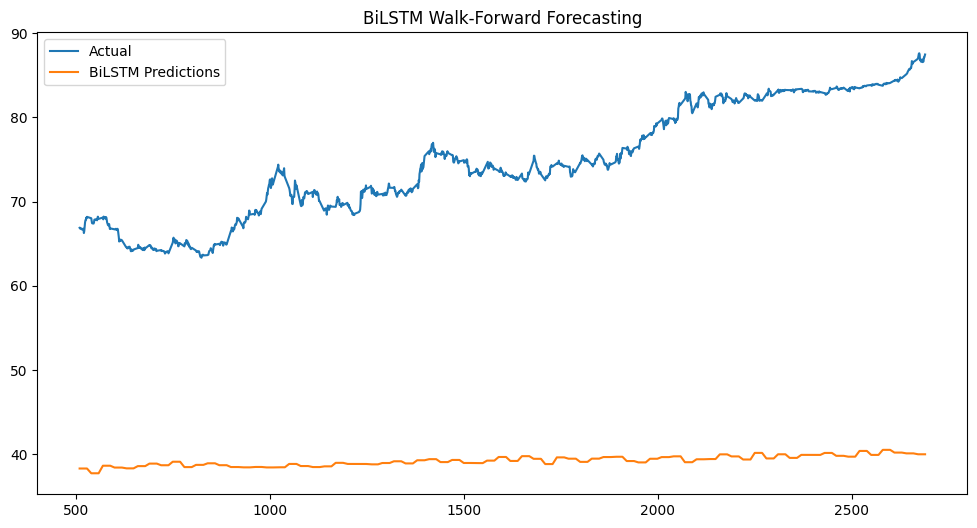

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# ====================
# Prepare Data
# ====================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

# scale optional: you can normalize if needed
# ====================
# BiLSTM Model
# ====================
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(BiLSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, 1)  # *2 for bidirectional

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        return self.fc(out)

# ====================
# Helper Functions
# ====================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

def create_sequences(X, y, seq_len=10):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:(i+seq_len)])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# ====================
# Walk-Forward Params
# ====================
train_window = 500
test_window = 30
seq_len = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds, all_actuals, all_idx, all_metrics = [], [], [], []

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train_raw, y_train_raw = X[start:end], y[start:end]
    X_test_raw, y_test_raw = X[end:end+test_window], y[end:end+test_window]

    # Create sequences
    X_train, y_train = create_sequences(X_train_raw, y_train_raw, seq_len)
    X_test, y_test = create_sequences(X_test_raw, y_test_raw, seq_len)

    train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).unsqueeze(-1))
    test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test).unsqueeze(-1))

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # Init model
    model = BiLSTMRegressor(input_dim=X.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    model.train()
    for epoch in range(20):  # keep small for walk-forward
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Predict
    # Predict
    # Predict
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().squeeze().tolist()   # stay as Python list
            preds_list.extend(preds)
            actual_list.extend(yb.squeeze().tolist())



    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end+seq_len, end+seq_len+len(preds_list)))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)
    da = directional_accuracy(actual_list, preds_list)

    # Trading metrics
    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ====================
# Collect Results
# ====================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_bilstm = preds_list
# ====================
# Plot Predictions
# ====================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="BiLSTM Predictions")
plt.legend()
plt.title("BiLSTM Walk-Forward Forecasting")
plt.show()


## CNN

Shape: (2680, 30, 10) (2680,)
    Fold        MAE       RMSE            R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  19.874313  19.880541  -2291.346402  0.235473  0.063996    -0.004032   
1      2  20.026467  20.243186  -1969.611092 -0.842455 -0.214191    -0.009498   
2      3   7.950044   8.307516   -172.726993 -1.626585 -0.229710    -0.020831   
3      4   9.223218   9.227520  -1010.893999  0.340503  0.262765     0.000000   
4      5   3.849446   3.968177   -375.505744 -0.276937 -0.096074    -0.003723   
..   ...        ...        ...           ...       ...       ...          ...   
67    68   6.117889   6.137948 -12046.068694 -0.229416 -0.120102    -0.003203   
68    69   6.411338   6.440899  -1089.531733 -0.161330 -0.108489    -0.004235   
69    70   2.844682   4.333057   -454.017104  0.372785  0.252691     0.000000   
70    71   8.522369   8.658534   -205.031200  0.505727  0.199322    -0.003704   
71    72   5.246665   7.178269   -324.460768  1.862928  0.373288    -0.003558  

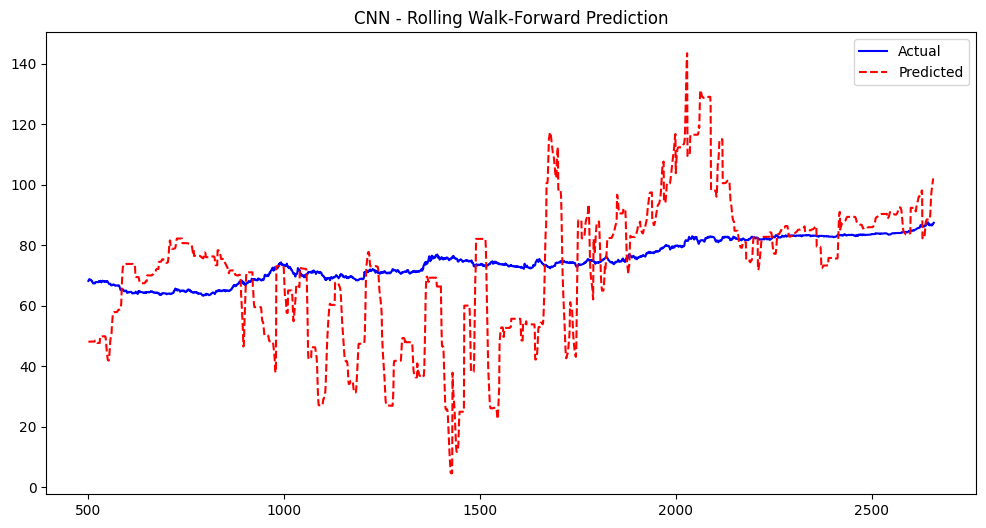

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days to use
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

# Function to build sequences
def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# CNN Model
# ===================
class CNN1D(nn.Module):
    def __init__(self, input_dim, lookback):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # input: (batch, lookback, features)
        x = x.permute(0, 2, 1)   # -> (batch, features, lookback)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = CNN1D(input_dim=X_train.shape[2], lookback=lookback).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())


    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_cnn = preds_list
# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("CNN - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## CNN- LSTM


Shape: (2680, 30, 10) (2680,)
    Fold       MAE      RMSE          R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  2.628462  2.660266  -40.046283  0.544062  0.107044    -0.004769   
1      2  2.089858  2.139164  -21.005499 -1.713056 -0.323174    -0.018856   
2      3  0.647099  0.672190   -0.137389 -1.253084 -0.226483    -0.015973   
3      4  1.738560  1.762711  -35.925591  0.691115  0.177474    -0.002768   
4      5  1.997715  2.008138  -95.422093 -0.776227 -0.138149    -0.010848   
..   ...       ...       ...         ...       ...       ...          ...   
67    68  1.306719  1.307915 -546.008216  0.062631  0.034038    -0.002632   
68    69  3.019954  3.026238 -239.741678  0.515182  0.316495    -0.000476   
69    70  1.471650  1.485588  -52.485468  0.831922  0.366465    -0.000968   
70    71  2.772705  2.837590  -21.128076  1.445646  0.343868    -0.001622   
71    72  3.848870  3.869296  -93.563384  1.792063  0.237999    -0.009430   

    DirAcc(%)  
0   58.620690  
1   27.586207

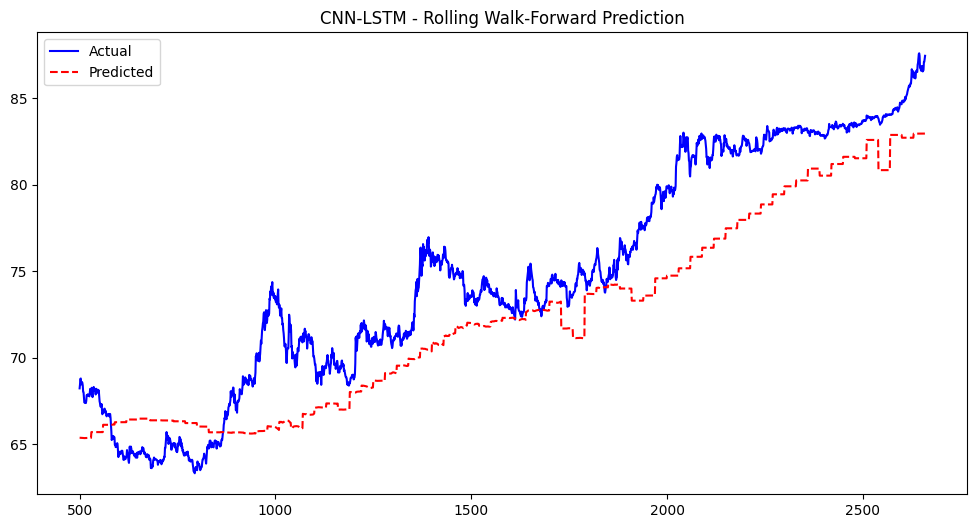

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # days of history per sample
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# CNN-LSTM Model
# ===================
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        x = x.permute(0, 2, 1)         # -> (batch, features, lookback)
        x = self.conv1(x)              # -> (batch, 32, lookback-2)
        x = self.relu(x)
        x = x.permute(0, 2, 1)         # -> (batch, seq_len, 32)
        out, _ = self.lstm(x)          # -> (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = CNN_LSTM(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("CNN-LSTM - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## GRU

Shape: (2680, 30, 10) (2680,)
    Fold       MAE      RMSE          R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  2.538628  2.572284  -37.376169  0.686688  0.160431    -0.004032   
1      2  2.009616  2.060413  -19.415108 -1.020371 -0.246862    -0.012095   
2      3  0.640117  0.665664   -0.115411 -1.865434 -0.327794    -0.021627   
3      4  1.835143  1.858155  -40.032574 -1.029251 -0.154387    -0.014907   
4      5  1.958866  1.969516  -91.748839  1.932335  0.282081    -0.003042   
..   ...       ...       ...         ...       ...       ...          ...   
67    68  1.286319  1.287536 -529.094815 -0.393005 -0.284266    -0.003926   
68    69  1.049370  1.067323  -28.945875  0.103143  0.060502    -0.002684   
69    70  1.599846  1.612691  -62.029131  0.892030  0.412515    -0.000829   
70    71  2.439548  2.513290  -16.359194  0.639414  0.320763    -0.000424   
71    72  3.705831  3.727087  -86.740127  1.519371  0.260654    -0.006037   

    DirAcc(%)  
0   48.275862  
1   48.275862

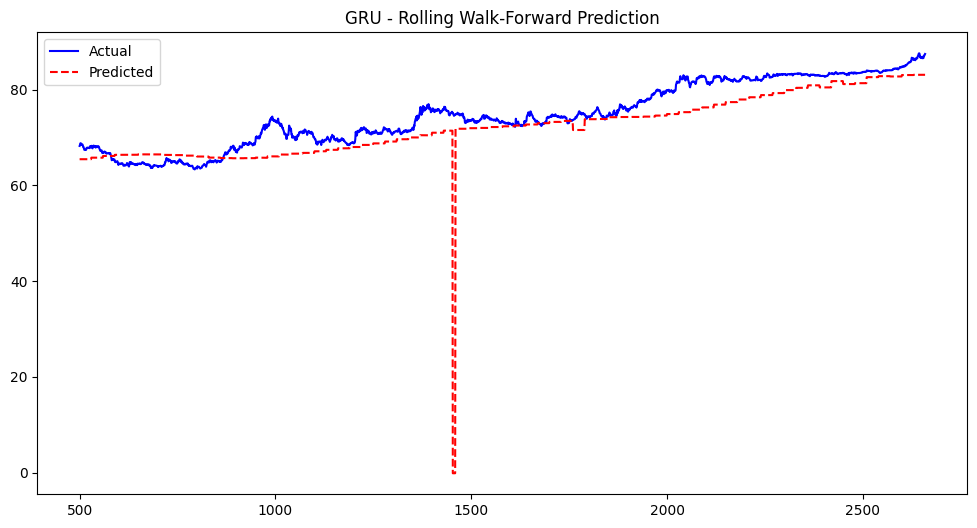

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days per sequence
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# GRU Model
# ===================
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        out, _ = self.gru(x)           # (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = GRUModel(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_gru = preds_list
# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("GRU - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## LSTM


Shape: (2680, 30, 10) (2680,)
    Fold       MAE      RMSE          R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  2.550275  2.583867  -37.722579 -0.670139 -0.107041    -0.015194   
1      2  1.984678  2.035502  -18.924439 -1.407428 -0.240579    -0.015940   
2      3  0.647915  0.672568   -0.138668 -1.072501 -0.235285    -0.012487   
3      4  1.823026  1.846160  -39.504525 -0.144628 -0.026579    -0.006119   
4      5  1.998172  2.008671  -95.473275  0.355707  0.064271    -0.007129   
..   ...       ...       ...         ...       ...       ...          ...   
67    68  1.252903  1.254146 -501.957088 -0.332233 -0.240768    -0.003427   
68    69  1.049201  1.067136  -28.935387  0.077951  0.046027    -0.002684   
69    70  1.429347  1.443739  -49.514533  0.825378  0.373800    -0.000829   
70    71  2.759015  2.824391  -20.922702  0.646723  0.248215    -0.001622   
71    72  4.065936  4.085201 -104.411041  1.247020  0.217226    -0.006037   

    DirAcc(%)  
0   44.827586  
1   44.827586

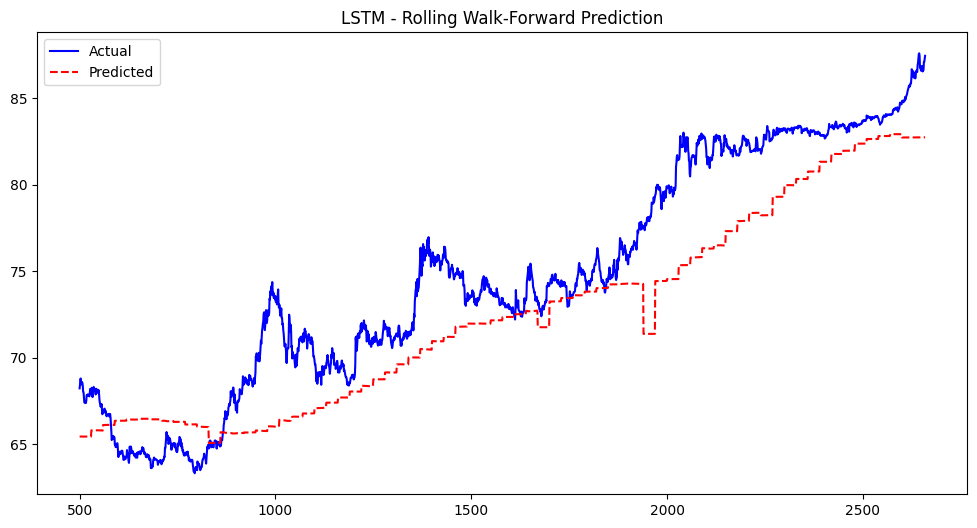

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days per sequence
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# LSTM Model
# ===================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        out, _ = self.lstm(x)          # (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_lstm = preds_list

# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("LSTM - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## PROPHET

15:09:09 - cmdstanpy - INFO - Chain [1] start processing
15:09:20 - cmdstanpy - INFO - Chain [1] done processing
15:09:21 - cmdstanpy - INFO - Chain [1] start processing
15:09:21 - cmdstanpy - INFO - Chain [1] done processing
15:09:22 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing
15:09:23 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing
15:09:24 - cmdstanpy - INFO - Chain [1] start processing
15:09:25 - cmdstanpy - INFO - Chain [1] done processing
15:09:25 - cmdstanpy - INFO - Chain [1] start processing
15:09:25 - cmdstanpy - INFO - Chain [1] done processing
15:09:26 - cmdstanpy - INFO - Chain [1] start processing
15:09:27 - cmdstanpy - INFO - Chain [1] done processing
15:09:27 - cmdstanpy - INFO - Chain [1] start processing
15:09:27 - cmdstanpy - INFO - Chain [1] done processing
15:09:28 - cmdstanpy - INFO - Chain [1] start processing
15:09:28 - cmdstanpy - INFO - Chain [1]


=== Prophet WITH Regressors ===
    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.119126  0.155941  0.897982  3.612102  0.527850    -0.001307   
1      2  0.380116  0.472487 -0.294802  2.234201  0.495362     0.000000   
2      3  0.130104  0.161318  0.874856  2.085876  0.458486    -0.000969   
3      4  0.237234  0.268341  0.818742  0.846705  0.310506    -0.001345   
4      5  0.584404  0.649542 -4.013939  1.420115  0.380770    -0.002184   
..   ...       ...       ...       ...       ...       ...          ...   
68    69  0.135662  0.157520 -6.934434  0.647745  0.520084    -0.000191   
69    70  0.183972  0.246722 -0.600149  0.750255  0.406704    -0.001142   
70    71  0.094275  0.109762  0.708029  1.118864  0.482084    -0.000968   
71    72  0.261077  0.368261  0.627304  2.644004  0.630859    -0.001788   
72    73  0.121761  0.160179  0.837942  3.240785  0.683985    -0.000912   

    DirAcc(%)  
0   79.310345  
1   79.310345  
2   79.310345  
3 

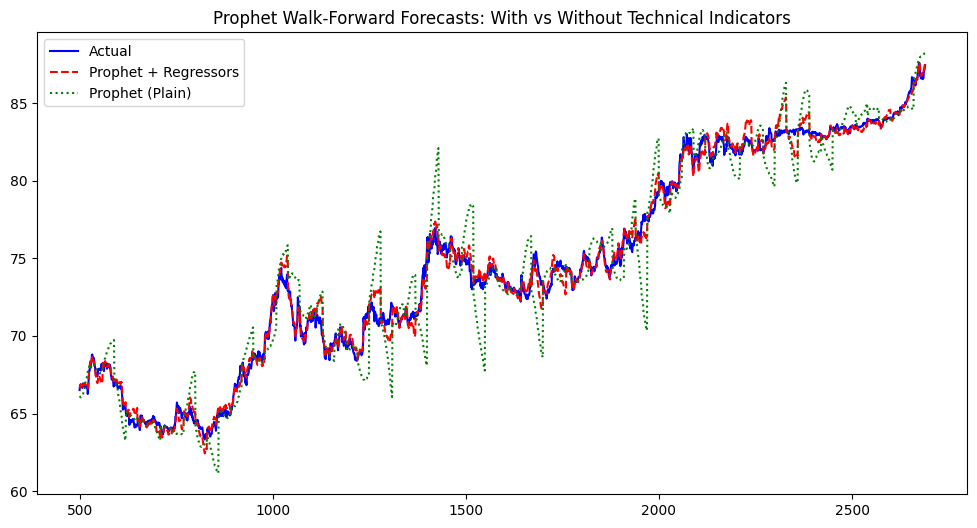

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===================
# Parameters
# ===================
train_window = 500
test_window = 30

# Prophet requires 'ds' and 'y'
df_prophet = df[['Date', 'Closing_price',
                 'EMA_100', 'EMA_200', 'EMA_50',
                 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
                 'SMA', 'Upper Band', 'Lower Band']].copy()

df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Closing_price': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Regressors to add
regressors = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]

# ===================
# Utility function
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

def evaluate_strategy(y_test, y_pred):
    """Compute metrics for forecasts"""
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(y_test, y_pred)

    return [mae, rmse, r2, roi, sharpe, max_dd, da]

# ===================
# Walk-forward Prophet with & without regressors
# ===================
metrics_with, metrics_without = [], []
all_preds_with, all_preds_without = [], []
all_actuals, all_idx = [], []

for fold, start in enumerate(range(0, len(df_prophet) - train_window - test_window, test_window), 1):
    end = start + train_window
    train = df_prophet.iloc[start:end]
    test = df_prophet.iloc[end:end+test_window]

    # ---- Prophet WITH regressors ----
    model_with = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    for reg in regressors:
        model_with.add_regressor(reg)
    model_with.fit(train[['ds', 'y'] + regressors])

    future_with = test[['ds'] + regressors].copy()
    forecast_with = model_with.predict(future_with)

    y_pred_with = forecast_with['yhat'].values
    y_test = test['y'].values

    metrics_with.append([fold] + evaluate_strategy(y_test, y_pred_with))
    all_preds_with.extend(y_pred_with)

    # ---- Prophet WITHOUT regressors ----
    model_plain = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model_plain.fit(train[['ds', 'y']])

    future_plain = test[['ds']].copy()
    forecast_plain = model_plain.predict(future_plain)

    y_pred_plain = forecast_plain['yhat'].values
    metrics_without.append([fold] + evaluate_strategy(y_test, y_pred_plain))
    all_preds_without.extend(y_pred_plain)

    # Save actuals
    all_actuals.extend(y_test)
    all_idx.extend(test.index)

# ===================
# Collect metrics
# ===================
cols = ['Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)']
metrics_with_df = pd.DataFrame(metrics_with, columns=cols)
metrics_without_df = pd.DataFrame(metrics_without, columns=cols)

print("\n=== Prophet WITH Regressors ===")
print(metrics_with_df)
print("\nAverage performance:")
print(metrics_with_df.mean())

print("\n=== Prophet WITHOUT Regressors ===")
print(metrics_without_df)
print("\nAverage performance:")
print(metrics_without_df.mean())

# ===================
# Plot comparison
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds_with, label="Prophet + Regressors", color="red", linestyle="dashed")
plt.plot(all_idx, all_preds_without, label="Prophet (Plain)", color="green", linestyle="dotted")
plt.title("Prophet Walk-Forward Forecasts: With vs Without Technical Indicators")
plt.legend()
plt.show()


15:11:44 - cmdstanpy - INFO - Chain [1] start processing
15:11:45 - cmdstanpy - INFO - Chain [1] done processing
15:11:46 - cmdstanpy - INFO - Chain [1] start processing
15:11:47 - cmdstanpy - INFO - Chain [1] done processing
15:11:47 - cmdstanpy - INFO - Chain [1] start processing
15:11:48 - cmdstanpy - INFO - Chain [1] done processing
15:11:49 - cmdstanpy - INFO - Chain [1] start processing
15:11:51 - cmdstanpy - INFO - Chain [1] done processing
15:11:51 - cmdstanpy - INFO - Chain [1] start processing
15:11:52 - cmdstanpy - INFO - Chain [1] done processing
15:11:52 - cmdstanpy - INFO - Chain [1] start processing
15:11:53 - cmdstanpy - INFO - Chain [1] done processing
15:11:53 - cmdstanpy - INFO - Chain [1] start processing
15:11:54 - cmdstanpy - INFO - Chain [1] done processing
15:11:55 - cmdstanpy - INFO - Chain [1] start processing
15:11:55 - cmdstanpy - INFO - Chain [1] done processing
15:11:56 - cmdstanpy - INFO - Chain [1] start processing
15:11:56 - cmdstanpy - INFO - Chain [1]

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.108663  0.142469  0.914848  3.612102  0.527850    -0.001307   
1      2  0.478997  0.581796 -0.963209  2.234201  0.495362     0.000000   
2      3  0.102889  0.132535  0.915530  2.085876  0.458486    -0.000969   
3      4  0.232597  0.264611  0.823745  0.846705  0.310506    -0.001345   
4      5  0.625274  0.691709 -4.686055  1.420115  0.380770    -0.002184   
..   ...       ...       ...       ...       ...       ...          ...   
68    69  0.161624  0.185371 -9.988172  0.647745  0.520084    -0.000191   
69    70  0.209519  0.278302 -1.036006  0.750255  0.406704    -0.001142   
70    71  0.098286  0.113367  0.688534  1.118864  0.482084    -0.000968   
71    72  0.325302  0.442767  0.461243  2.512103  0.596616    -0.001788   
72    73  0.103893  0.142612  0.871539  3.253511  0.688060    -0.000912   

    DirAcc(%)  
0   79.310345  
1   79.310345  
2   79.310345  
3   72.413793  
4   72.413793  
.. 

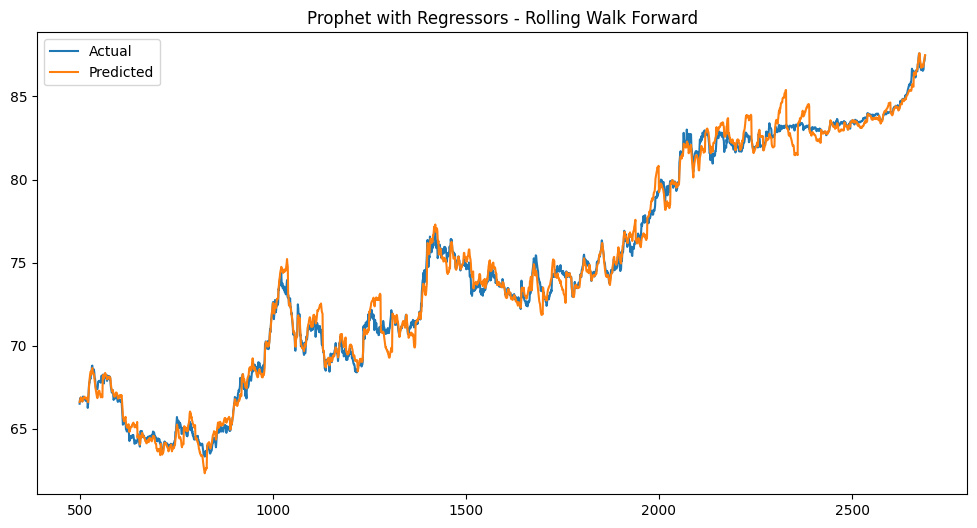

In [26]:
 
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Prepare data ===
# df = your dataframe
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

# Prophet requires "ds" (date) and "y" (target)
prophet_df = df[['Date', target] + features].rename(columns={'Date': 'ds', target: 'y'})

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(prophet_df) - train_window - test_window, test_window), 1):
    end = start + train_window
    train_df = prophet_df.iloc[start:end]
    test_df = prophet_df.iloc[end:end+test_window]

    # Prophet model
    model = Prophet(
        daily_seasonality=False,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=5
    )
    for f in features:
        model.add_regressor(f)

    model.fit(train_df)

    forecast = model.predict(test_df)
    y_pred = forecast['yhat'].values
    y_test = test_df['y'].values

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(test_df.index)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_prophet = y_pred
# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("Prophet with Regressors - Rolling Walk Forward")
plt.show()


## SARIMA

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roamin

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.170632  0.282188  0.665933  3.612102  0.527850    -0.001307   
1      2  0.128819  0.155888  0.859055  2.218857  0.487485    -0.000811   
2      3  0.177126  0.207842  0.792264  2.085876  0.458486    -0.000969   
3      4  0.215822  0.287851  0.791427  0.876161  0.344218    -0.001222   
4      5  0.066258  0.083501  0.917139  1.358185  0.363395    -0.002184   
..   ...       ...       ...       ...       ...       ...          ...   
68    69  0.045906  0.051980  0.135981  0.678744  0.547221    -0.000191   
69    70  0.077564  0.094811  0.763699  0.921628  0.551217    -0.000357   
70    71  0.110986  0.130757  0.585653  1.152091  0.501548    -0.000968   
71    72  0.122267  0.152557  0.936040  2.581786  0.609019    -0.001788   
72    73  0.122520  0.150314  0.857288  3.307820  0.703920    -0.000912   

    DirAcc(%)  
0   79.310345  
1   79.310345  
2   79.310345  
3   72.413793  
4   68.965517  
.. 

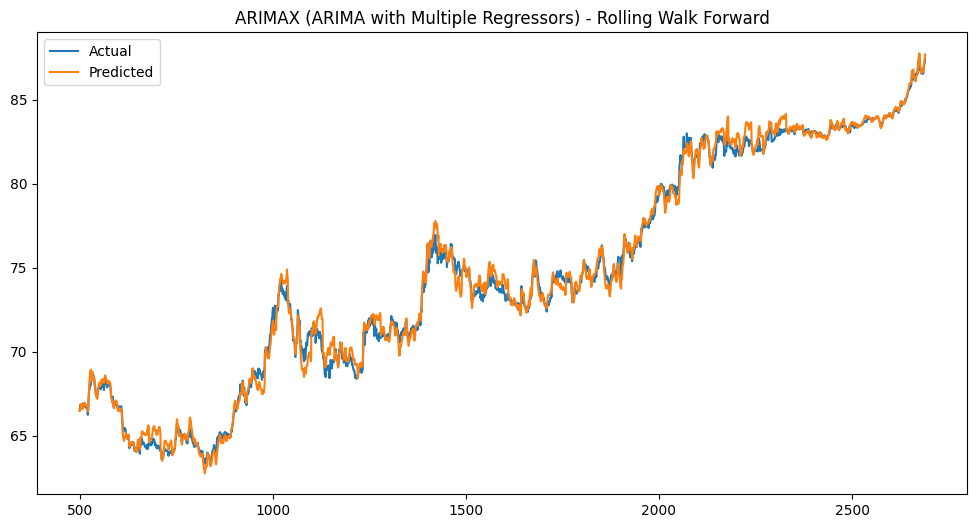

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare data ===
# df = your dataframe
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit ARIMAX model (simple ARIMA(1,1,1) here, can tune with auto_arima)
    try:
        model = SARIMAX(y_train,
                        exog=X_train,
                        order=(1, 1, 1),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        y_pred = results.predict(start=len(y_train),
                                 end=len(y_train)+len(y_test)-1,
                                 exog=X_test)

    except Exception as e:
        print(f"Fold {fold} failed: {e}")
        continue

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("ARIMAX (ARIMA with Multiple Regressors) - Rolling Walk Forward")
plt.show()


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roamin

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.155393  0.252766  0.731964  3.612102  0.527850    -0.001307   
1      2  0.156571  0.181829  0.808244  2.177322  0.475585    -0.000811   
2      3  0.171247  0.204060  0.799755  2.085876  0.458486    -0.000969   
3      4  0.237504  0.313621  0.752409  0.793943  0.313560    -0.001222   
4      5  0.082553  0.101241  0.878191  1.358175  0.364168    -0.002184   
..   ...       ...       ...       ...       ...       ...          ...   
68    69  0.048718  0.054781  0.040379  0.678744  0.547221    -0.000191   
69    70  0.087095  0.104173  0.714731  0.921628  0.551217    -0.000357   
70    71  0.115103  0.135260  0.556618  1.152091  0.501548    -0.000968   
71    72  0.075147  0.087602  0.978910  2.581786  0.609019    -0.001788   
72    73  0.138166  0.165856  0.826250  3.307820  0.703920    -0.000912   

    DirAcc(%)  
0   79.310345  
1   75.862069  
2   79.310345  
3   68.965517  
4   68.965517  
.. 

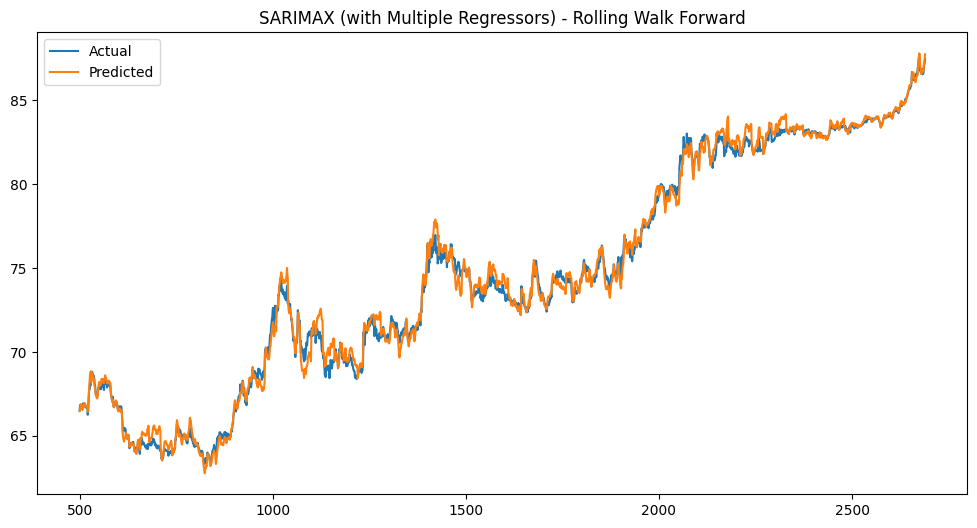

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare data ===
# df = your dataframe
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    try:
        # SARIMAX with seasonality (set seasonal_order=(P,D,Q,s))
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=(1, 1, 1),                # ARIMA(p,d,q)
            seasonal_order=(1, 0, 1, 12),   # SARIMA(P,D,Q,s) -> here s=12 (monthly seasonality example)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)

        y_pred = results.predict(
            start=len(y_train),
            end=len(y_train)+len(y_test)-1,
            exog=X_test
        )

    except Exception as e:
        print(f"Fold {fold} failed: {e}")
        continue

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_sarima = y_pred
# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("SARIMAX (with Multiple Regressors) - Rolling Walk Forward")
plt.show()


## Diebold–Mariano (DM) test i

In [31]:
from itertools import combinations
from scipy import stats

# ======================================
# Helper: Diebold-Mariano Test
# ======================================
def diebold_mariano(y_true, y_pred1, y_pred2, crit="MSE"):
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2

    if crit.upper() == "MSE":
        d = e1**2 - e2**2
    elif crit.upper() == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))
    return dm_stat, p_value

# ======================================
# Step 1 – Collect predictions
# ======================================
# Suppose after each model you save predictions on the SAME test folds:
# y_actual_series = actual values (same for all models!)
# Store each model's preds in a dict:

all_model_preds = {
    "LinearRegression": y_pred_lr,     # np.array or pd.Series
    "CatBoost": y_pred_cat,
    "LightGBM": y_pred_lgb,
    "MLP": y_pred_mlp,
    "SVM": y_pred_svr,
    "BiLSTM": y_pred_bilstm,
    "GRU": y_pred_gru,
    "LSTM": y_pred_lstm,
    "CNN": y_pred_cnn,
    "Prophet": y_pred_prophet,
    "SARIMA": y_pred_sarima
}

# Make sure all are aligned with actuals
y_true = np.array(y_actual_series)

# ======================================
# Step 2 – Run DM tests across all pairs
# ======================================
dm_results = []

for (m1, m2) in combinations(all_model_preds.keys(), 2):
    y1 = np.array(all_model_preds[m1])
    y2 = np.array(all_model_preds[m2])

    # Align lengths
    min_len = min(len(y_true), len(y1), len(y2))
    y_true_aligned = y_true[-min_len:]
    y1, y2 = y1[-min_len:], y2[-min_len:]

    dm_stat, p_value = diebold_mariano(y_true_aligned, y1, y2, crit="MSE")
    dm_results.append([m1, m2, dm_stat, p_value])

dm_df = pd.DataFrame(dm_results, columns=["Model 1", "Model 2", "DM Stat", "p-value"])
print("\n=== Diebold-Mariano Test Results ===")
print(dm_df)

# ======================================
# Step 3 – Average performance summary
# ======================================
perf_summary = []
for name, preds in all_model_preds.items():
    preds = np.array(preds)
    min_len = min(len(y_true), len(preds))
    y_t, y_p = y_true[-min_len:], preds[-min_len:]

    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)

    # Trading metrics
    pred_returns = pd.Series(y_p).pct_change().fillna(0)
    actual_returns = pd.Series(y_t).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    def directional_accuracy(actual, predicted):
        actual_diff = np.diff(actual)
        pred_diff = np.diff(predicted)
        return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    da = directional_accuracy(y_t, y_p)

    perf_summary.append([name, mae, rmse, r2, roi, sharpe, max_dd, da])

perf_df = pd.DataFrame(perf_summary, columns=[
    "Model", "MAE", "RMSE", "R2", "ROI(%)", "Sharpe", "MaxDrawdown", "DirAcc(%)"
])

print("\n=== Average Performance Across Models ===")
print(perf_df.sort_values(by="R2", ascending=False))



=== Diebold-Mariano Test Results ===
             Model 1   Model 2     DM Stat       p-value
0   LinearRegression  CatBoost   -7.517784  5.573320e-14
1   LinearRegression  LightGBM   -8.600892  0.000000e+00
2   LinearRegression       MLP    5.344996  9.041898e-08
3   LinearRegression       SVM   -4.567333  4.939695e-06
4   LinearRegression    BiLSTM -309.584823  0.000000e+00
5   LinearRegression       GRU  -26.181302  0.000000e+00
6   LinearRegression      LSTM  -28.865621  0.000000e+00
7   LinearRegression       CNN   -3.681307  2.320411e-04
8   LinearRegression   Prophet    3.053144  2.264574e-03
9   LinearRegression    SARIMA    3.052614  2.268576e-03
10          CatBoost  LightGBM    1.539793  1.236107e-01
11          CatBoost       MLP    5.627061  1.833055e-08
12          CatBoost       SVM   -7.891646  2.886580e-15
13          CatBoost    BiLSTM -298.916664  0.000000e+00
14          CatBoost       GRU  -19.719944  0.000000e+00
15          CatBoost      LSTM  -22.803349  0.0000

In [32]:
# === Save test set for reuse ===
test_set = df.iloc[end:end+test_window].copy()

# Save to CSV
test_set.to_csv("forex_test_set.csv", index=False)

# Or save as pickle (preserves dtypes better)
import pickle
with open("forex_test_set.pkl", "wb") as f:
    pickle.dump(test_set, f)

print("✅ Test set saved: forex_test_set.csv and forex_test_set.pkl")


✅ Test set saved: forex_test_set.csv and forex_test_set.pkl
